In [ ]:
import os
import sys
import shutil
import argparse
import math
import IPython 
from PIL import Image
from enum import Enum
from typing import Callable, List, Optional, Tuple, Union
from functools import partial

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import VisionDataset
from torchvision.transforms import transforms
import numpy as np
import pandas as pd
import skimage
from scipy import sparse
import matplotlib.pyplot as plt 
import torchxrayvision as xrv

from fvcore.common.checkpoint import Checkpointer, PeriodicCheckpointer
from dinov2.models.unet import UNet
from dinov2.data import SamplerType, make_data_loader, make_dataset
from dinov2.data.datasets import NIHChestXray, MC, Shenzhen, SARSCoV2CT
from dinov2.data.datasets.medical_dataset import MedicalVisionDataset
from dinov2.data.loaders import make_data_loader
from dinov2.data.transforms import (make_segmentation_transform, make_classification_eval_transform, make_segmentation_target_transform,
                                    make_classification_train_transform)
from dinov2.eval.setup import setup_and_build_model
from dinov2.eval.utils import is_zero_matrix, ModelWithIntermediateLayers, ModelWithNormalize, evaluate, extract_features, collate_fn_3d
from dinov2.eval.classification.linear import LinearClassifier, create_linear_input
from dinov2.eval.metrics import build_segmentation_metrics
from dinov2.eval.segmentation.utils import LinearDecoder, setup_decoders
from dinov2.utils import show_image_from_tensor

In [ ]:
args = argparse.Namespace(config_file='dinov2/configs/eval/vits14_pretrain.yaml', pretrained_weights='models/dinov2_vits14_pretrain.pth', output_dir='results/NIH/dinov2_vits14/knn', opts=[], train_dataset_str='NIHChestXray:split=TRAIN:root=/mnt/d/data/NIH', val_dataset_str='NIHChestXray:split=VAL:root=/mnt/d/data/NIH', test_dataset_str='NIHChestXray:split=TEST:root=/mnt/d/data/NIH', nb_knn=[5, 20, 50, 100, 200], temperature=0.07, gather_on_cpu=False, batch_size=8, n_per_class_list=[-1], n_tries=1, ngpus=1, nodes=1, timeout=2800, partition='learnlab', use_volta32=False, comment='', exclude='')
model, autocast_dtype = setup_and_build_model(args)
autocast_ctx = partial(torch.cuda.amp.autocast, enabled=True, dtype=autocast_dtype)
feature_model = ModelWithIntermediateLayers(model, 1, autocast_ctx)
# model = ModelWithNormalize(model)

In [ ]:
train_dataset_str = args.train_dataset_str
val_dataset_str = args.val_dataset_str
batch_size = args.batch_size
gather_on_cpu = args.gather_on_cpu
num_workers = 1

In [ ]:
transform = target_transform = make_classification_train_transform()
dataset = SARSCoV2CT(split=SARSCoV2CT.Split.TRAIN,
                root="/mnt/z/data/SARS-CoV-2-CT",
                transform=transform)

In [ ]:
for i, t in dataset:
    i = i[0]
    show_image_from_tensor(i)

In [ ]:
train_data_loader = make_data_loader(
    dataset=dataset,
    collate_fn=collate_fn_3d,
    batch_size=4,
    num_workers=1,
    shuffle=True,
    seed=0,
    sampler_type=None,
    sampler_advance=1,
    drop_last=False,
    persistent_workers=True,
)

In [ ]:
linear = nn.Linear(384, 1).cuda()
linear.bias.data.zero_()
linear.weight.data.normal_(mean=0.0, std=0.01)
print('')

In [ ]:
z = 0
f = 0
for i, t in train_data_loader:
    i = i.cuda()
    t = t.cuda()

    for batch_scans in i:
        scans = []
        for scan in batch_scans:
            if not is_zero_matrix(scan):
                features = feature_model(scan.unsqueeze(0))
                print(len(features))
                print(len(features[0]))
                scans.append(features)
                z+=1
        print(len(scans))
        print(scans[0].shape)
        
        aggregated_scans = torch.stack(scans)
        print(aggregated_scans)
        # output = linear(aggregated_scans)
        # print(output.shape)
        print(aggregated_scans.shape)
    print(z)
    print(f)
    break
    if z == 5:
        break
    z+=1

In [ ]:
for i, j in train_data_loader:
    print(i)

In [26]:
# transform = make_segmentation_transform(resize_size=224)
# target_transform = make_segmentation_target_transform(resize_size=224)
transform = target_transform = make_classification_train_transform()

train_dataset = make_dataset(
    dataset_str=args.train_dataset_str,
    transform=transform,
)
val_dataset = make_dataset(
    dataset_str=args.val_dataset_str,
    transform=transform,
)
test_dataset = make_dataset(
    dataset_str=args.test_dataset_str,
    transform=transform,
)

sampler_type = SamplerType.INFINITE

train_data_loader = make_data_loader(
    dataset=train_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=True,
    seed=0,
    sampler_type=sampler_type,
    sampler_advance=1,
    drop_last=False,
    persistent_workers=True,
)

val_data_loader = make_data_loader(
    dataset=val_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=True,
    seed=0,
    sampler_type=sampler_type,
    sampler_advance=1,
    drop_last=False,
    persistent_workers=True,
)

I20230912 16:24:13 2826 dinov2 loaders.py:94] using dataset: "NIHChestXray:split=TRAIN:root=/mnt/d/data/NIH"
0 scans are missing from TRAIN set
I20230912 16:24:18 2826 dinov2 loaders.py:99] # of dataset samples: 76,522
I20230912 16:24:18 2826 dinov2 loaders.py:94] using dataset: "NIHChestXray:split=VAL:root=/mnt/d/data/NIH"
0 scans are missing from VAL set
I20230912 16:24:18 2826 dinov2 loaders.py:99] # of dataset samples: 10,002
I20230912 16:24:18 2826 dinov2 loaders.py:94] using dataset: "NIHChestXray:split=TEST:root=/mnt/d/data/NIH"
0 scans are missing from TEST set
I20230912 16:24:19 2826 dinov2 loaders.py:99] # of dataset samples: 25,596
I20230912 16:24:19 2826 dinov2 loaders.py:122] sampler: infinite
I20230912 16:24:19 2826 dinov2 loaders.py:216] using PyTorch data loader
I20230912 16:24:19 2826 dinov2 loaders.py:231] infinite data loader
I20230912 16:24:19 2826 dinov2 loaders.py:122] sampler: infinite
I20230912 16:24:19 2826 dinov2 loaders.py:216] using PyTorch data loader
I2023

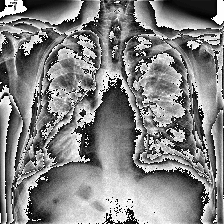

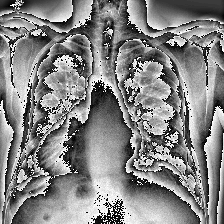

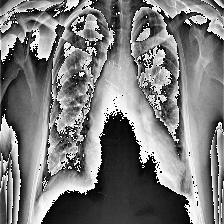

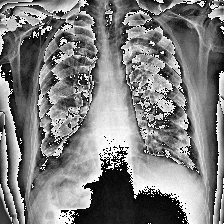

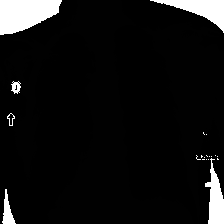

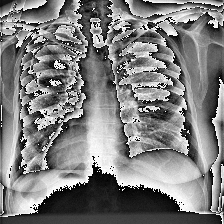

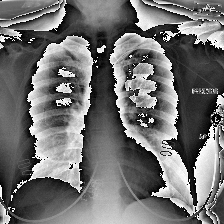

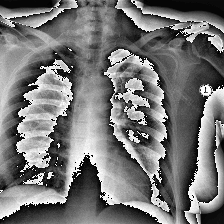

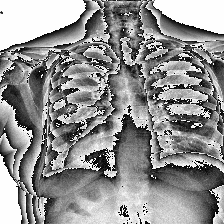

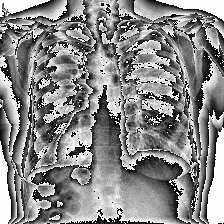

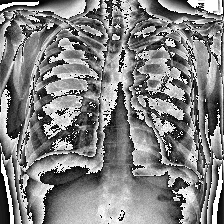

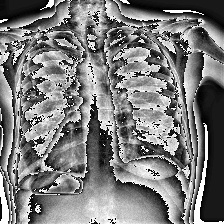

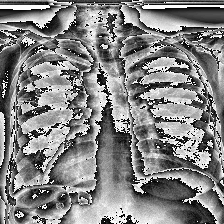

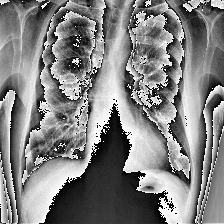

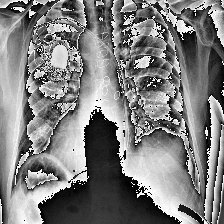

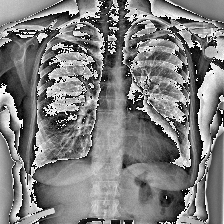

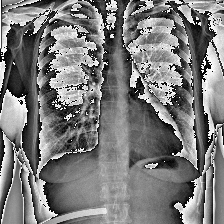

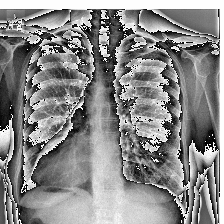

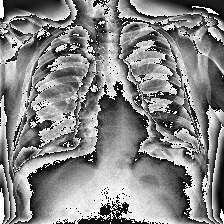

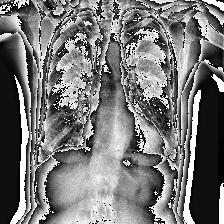

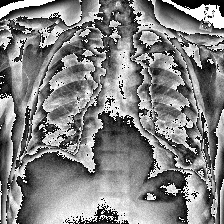

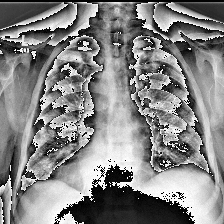

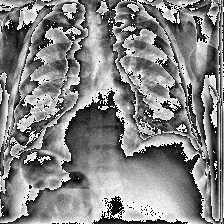

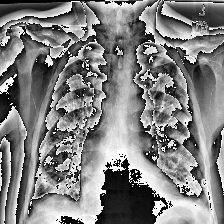

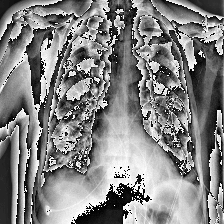

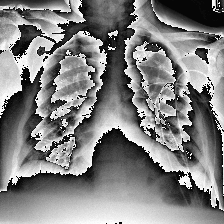

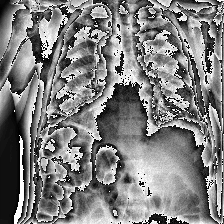

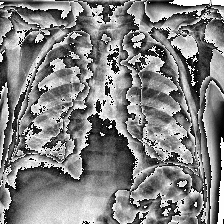

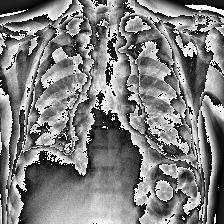

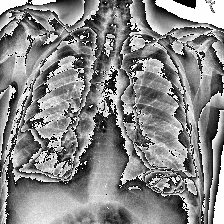

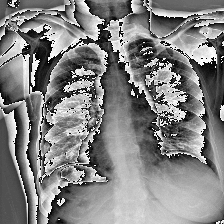

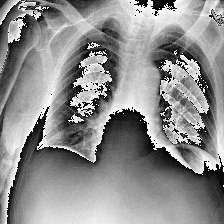

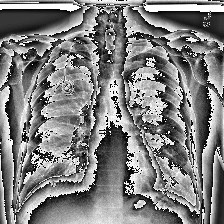

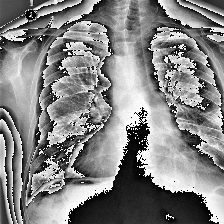

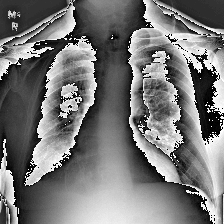

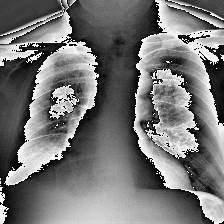

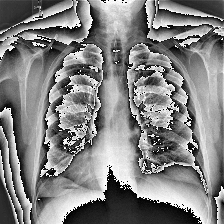

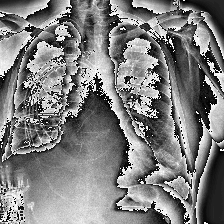

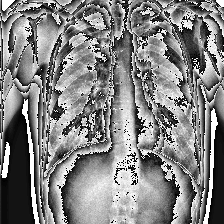

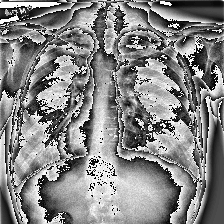

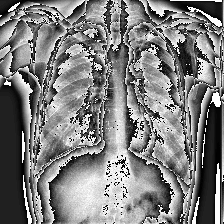

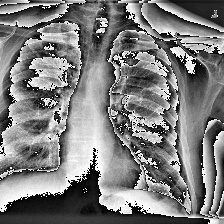

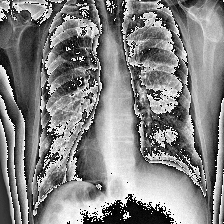

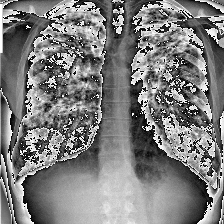

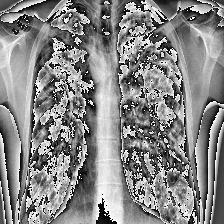

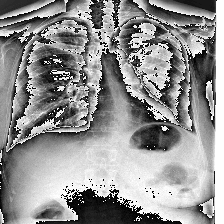

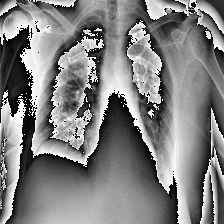

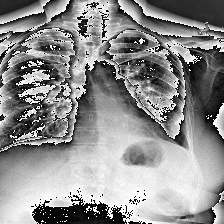

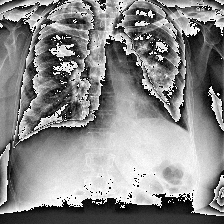

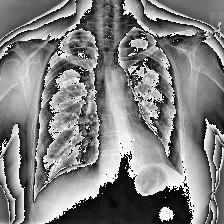

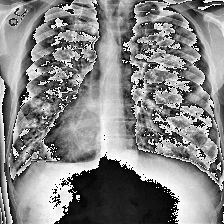

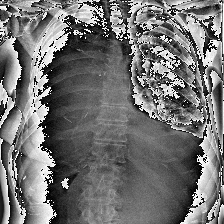

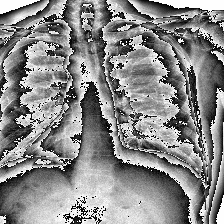

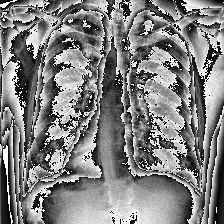

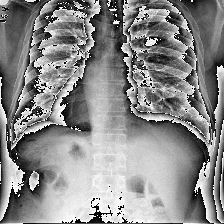

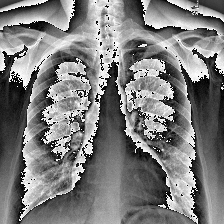

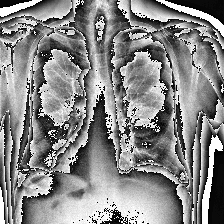

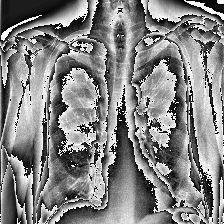

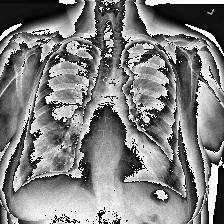

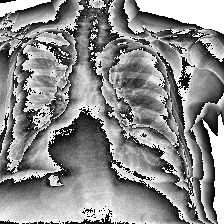

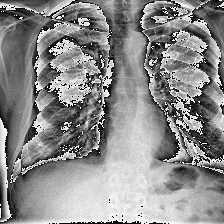

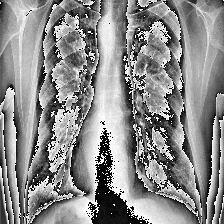

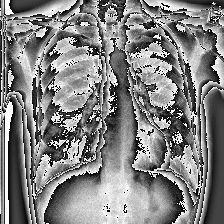

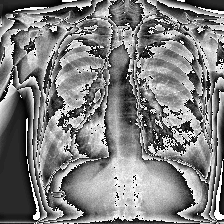

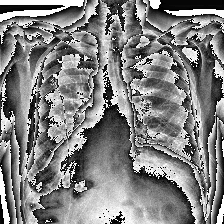

KeyboardInterrupt: 

In [29]:
for i, t in train_dataset:
    show_image_from_tensor(i)

In [ ]:
class LinearDecoder(torch.nn.Module):
    """Linear decoder head"""
    DECODER_TYPE = "linear"

    def __init__(self, in_channels, tokenW=32, tokenH=32, num_classes=3):
        super().__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.decoder = torch.nn.Conv2d(in_channels, num_classes, (1,1))
        self.decoder.weight.data.normal_(mean=0.0, std=0.01)
        self.decoder.bias.data.zero_()

    def forward(self, embeddings):
        print(embeddings.shape)
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        print(embeddings.shape)
        embeddings = embeddings.permute(0,3,1,2)
        print(embeddings.shape)

        return self.decoder(embeddings)

In [ ]:
d = LinearDecoder(384, num_classes=2).cuda()

In [ ]:
for i, t in train_dataset:
    i = i.cuda().unsqueeze(0)
    a = model(i)
    b = model.forward_features(i)['x_norm_patchtokens']
    z = d(b)
    print(z.shape)
    break

In [ ]:
concated = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

In [ ]:
len(concated)

In [ ]:
concated.get_num_classes()

In [ ]:
for i, t in concated:
    print(i)

In [ ]:
data_dir = "/mnt/d/data/NIH/"
train_val = pd.read_csv(data_dir + os.sep + "train_val_list.txt", names=["Image Index"])
val_list = [i for i in range(len(train_val)-10_002, len(train_val))]
val_set = train_val.iloc[val_list]
train_set = train_val.drop(val_list)

train_dir = data_dir + os.sep + "train"
val_dir = data_dir + os.sep + "val"
for image in val_set["Image Index"]:
    source = train_dir + os.sep + image
    dest = val_dir + os.sep + image
    shutil.move(source, dest)

val_set.to_csv(data_dir + os.sep + "val_list.txt", index=False, header=False)
train_set.to_csv(data_dir + os.sep + "train_list.txt", index=False, header=False)

In [ ]:
class LinearDecoder(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearDecoder, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.decoder = torch.nn.Conv2d(in_channels, num_labels, (1,1))
        self.decoder.weight.data.normal_(mean=0.0, std=0.01)
        self.decoder.bias.data.zero_()

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.decoder(embeddings)

In [ ]:
decoder = LinearDecoder(384, num_labels=3).cuda()
optimizer = torch.optim.SGD(params=decoder.parameters(), lr=0.0005, momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 69, eta_min=0)

In [ ]:
class MetricAveraging(Enum):
    MEAN_ACCURACY = "micro"
    MEAN_PER_CLASS_ACCURACY = "macro"
    MULTILABEL_ACCURACY = "macro"
    MULTILABEL_AUROC = "macro"
    MULTILABEL_JACCARD = "macro"
    PER_CLASS_ACCURACY = "none"

    def __str__(self):
        return self.value

metric = build_segmentation_metrics(average_type=MetricAveraging.MULTILABEL_JACCARD,num_labels=3)
metric.cuda()

In [ ]:
i = 0
for image, target in train_data_loader:
    i+=1
    image, target = image.cuda(non_blocking=True), target.cuda(non_blocking=True)
    with torch.no_grad(): 
        features=model.forward_features(image)['x_norm_patchtokens']
    logits = decoder(features)
    logits = torch.nn.functional.interpolate(logits, size=448, mode="bilinear", align_corners=False)
    prediction = logits.argmax(dim=1)

    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits, target)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    scheduler.step()

    metric(prediction, target)
    print(metric.compute())
    print(loss.item())

    # if i % 50 == 0:
    show_image_from_tensor((prediction * 100).cpu())
    show_image_from_tensor((target * 100).cpu())